In [167]:
import pandas as pd

data="./data/focus_clear_eval_detail.json"
# data="data/final_results.json"
# data="data/focus_unclear_eval_detail.json"

raw_df=pd.read_json(data)

# Đếm số lượng giá trị NaN trong mỗi cột
nan_counts = raw_df.isna().sum()

print("Số lượng bản ghi bị thiếu (NaN) trong mỗi cột:")
print(nan_counts[nan_counts > 0]) # Chỉ in ra các cột có giá trị NaN

Số lượng bản ghi bị thiếu (NaN) trong mỗi cột:
Series([], dtype: int64)


In [168]:
# In ra số lượng bản ghi ban đầu
print(f"Số lượng bản ghi ban đầu: {len(raw_df)}")

# Tạo một DataFrame mới đã được làm sạch, không chứa các hàng có NaN
cleaned_df = raw_df.dropna()

# In ra số lượng bản ghi sau khi lọc
print(f"Số lượng bản ghi sau khi lọc bỏ NaN: {len(cleaned_df)}")

# (Tùy chọn) Xem lại mô tả dữ liệu sau khi đã làm sạch
print("\nMô tả dữ liệu sau khi làm sạch:")
cleaned_df.describe()

Số lượng bản ghi ban đầu: 100
Số lượng bản ghi sau khi lọc bỏ NaN: 100

Mô tả dữ liệu sau khi làm sạch:


,tool_trajectory_avg_score,response_match_score,invocation_duration_ms,llm_duration_ms,tool_duration_ms,overhead_duration_ms,total_input_tokens,total_output_tokens,total_tokens,num_llm_calls,num_tool_calls,total_spans
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.840000,0.723921,48573.090680,46663.848570,1.309000,1907.933110,39700.580000,5034.270000,44734.850000,10.690000,2.670000,27.140000
std,0.368453,0.211583,21409.739663,21542.520122,0.866264,400.757334,26151.223403,2481.908201,28485.153625,4.315102,0.841535,9.247462
min,0.000000,0.056864,1476.903000,0.000000,0.000000,1017.781000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,0.678321,38543.941000,36822.848500,1.059750,1659.095250,23919.250000,3985.000000,28006.000000,9.000000,3.000000,24.000000
50%,1.000000,0.814439,47920.424500,46039.613000,1.186500,1837.033000,36835.500000,4869.000000,42257.500000,11.000000,3.000000,28.000000
75%,1.000000,0.857433,61886.947000,59682.956250,1.450750,2132.594000,52015.250000,6388.000000,58424.000000,13.000000,3.000000,32.000000
max,1.000000,0.908583,134751.275000,133467.183000,7.716000,2977.359000,174210.000000,15120.000000,189330.000000,23.000000,3.000000,52.000000


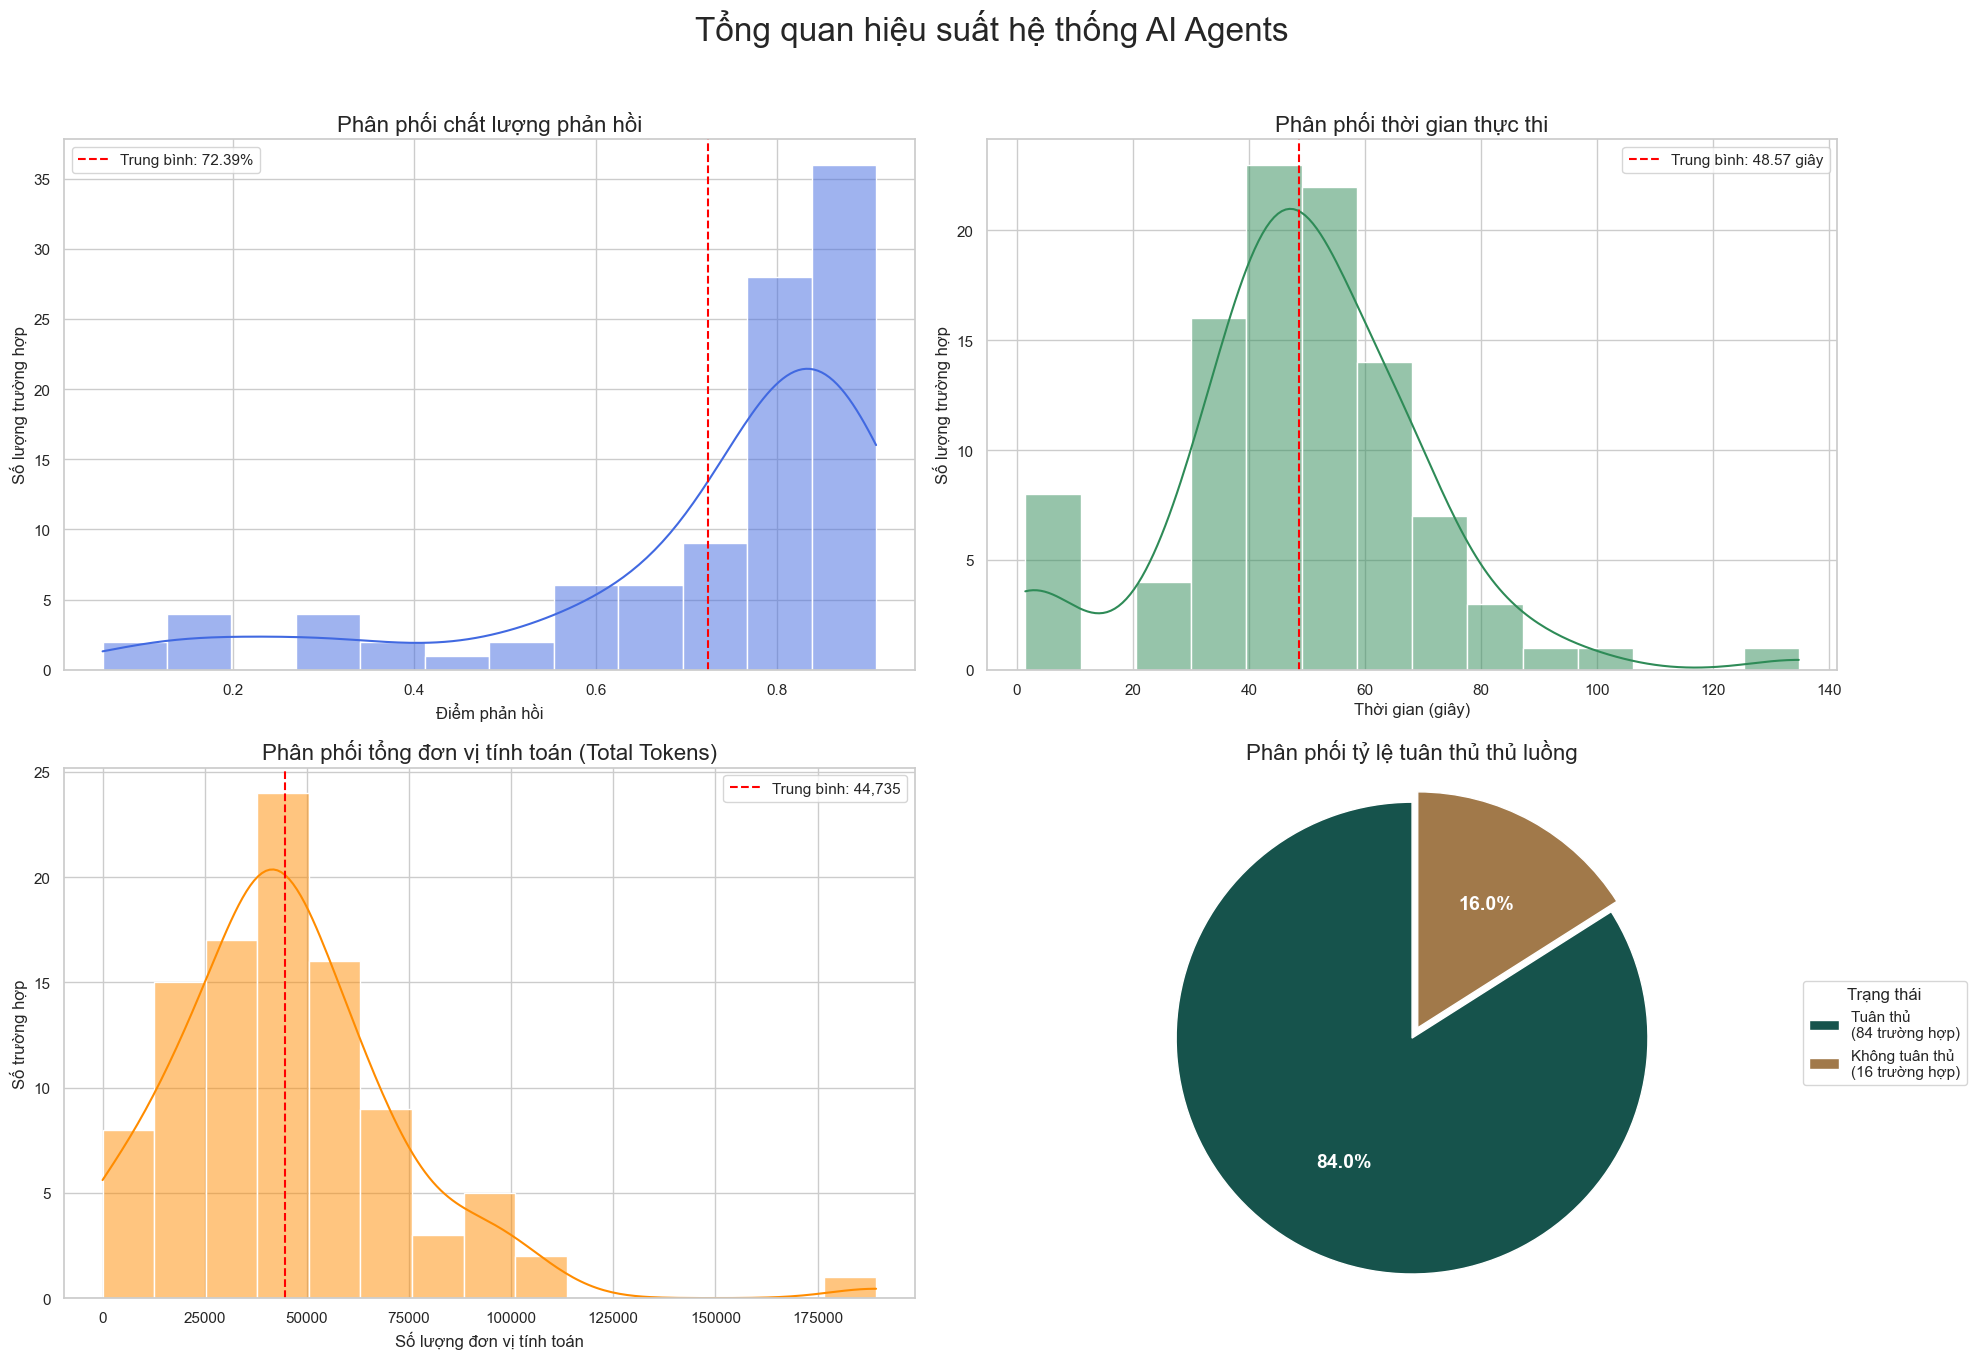

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Giả định bạn đã có một DataFrame tên là 'cleaned_df' từ bước trước ---
# cleaned_df = pd.read_json('path_to_your_final_data.json')

# --- Thiết lập chung ---
sns.set_theme(style="whitegrid")
# Tạo một lưới 2x2 để chứa 4 biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Tổng quan hiệu suất hệ thống AI Agents', fontsize=24, y=0.97)


# --- 1. Biểu đồ Phân phối Chất lượng ---
ax1 = axes[0, 0]
sns.histplot(data=cleaned_df, x='response_match_score', kde=True, ax=ax1, color='royalblue')
mean_score = cleaned_df['response_match_score'].mean()
ax1.axvline(mean_score, color='red', linestyle='--', label=f'Trung bình: {mean_score:.2%}')
ax1.set_title('Phân phối chất lượng phản hồi', fontsize=16)
ax1.set_xlabel('Điểm phản hồi', fontsize=12)
ax1.set_ylabel('Số lượng trường hợp', fontsize=12)
ax1.legend()


# --- 2. Biểu đồ Phân phối Hiệu suất ---
ax2 = axes[0, 1]
duration_seconds = cleaned_df['invocation_duration_ms'] / 1000
sns.histplot(duration_seconds, kde=True, ax=ax2, color='seagreen')
mean_duration = duration_seconds.mean()
ax2.axvline(mean_duration, color='red', linestyle='--', label=f'Trung bình: {mean_duration:.2f} giây')
ax2.set_title('Phân phối thời gian thực thi', fontsize=16)
ax2.set_xlabel('Thời gian (giây)', fontsize=12)
ax2.set_ylabel('Số lượng trường hợp', fontsize=12)
ax2.legend()


# --- 3. Biểu đồ Phân phối Chi phí ---
ax3 = axes[1, 0]
sns.histplot(data=cleaned_df, x='total_tokens', kde=True, ax=ax3, color='darkorange')
mean_tokens = cleaned_df['total_tokens'].mean()
ax3.axvline(mean_tokens, color='red', linestyle='--', label=f'Trung bình: {mean_tokens:,.0f}')
ax3.set_title('Phân phối tổng đơn vị tính toán (Total Tokens)', fontsize=16)
ax3.set_xlabel('Số lượng đơn vị tính toán', fontsize=12)
ax3.set_ylabel('Số trường hợp', fontsize=12)
ax3.legend()


# --- 4. Biểu đồ Tỷ lệ Tuân thủ Luồng (Dạng biểu đồ tròn) ---
ax4 = axes[1, 1]
# Đếm số lượng của mỗi giá trị
score_counts = cleaned_df["tool_trajectory_avg_score"].value_counts()
if len(score_counts) >= 2:
    labels = [
        f"Tuân thủ\n({score_counts.iloc[0]} trường hợp)",
        f"Không tuân thủ\n({score_counts.iloc[1]} trường hợp)",
    ]
elif len(score_counts) == 1:
    labels = [
        f"Tuân thủ\n({score_counts.iloc[0]} trường hợp)" if score_counts.index[0] == 1.0 else
        f"Không tuân thủ\n({score_counts.iloc[0]} trường hợp)"
    ]
sizes = [score_counts.get(1.0, 0), score_counts.get(0.0, 0)]
colors=sns.color_palette("cubehelix", 3)
explode = (0.05, 0)

# Bỏ `labels` khỏi đây để chúng không hiện trên biểu đồ
wedges, texts, autotexts = plt.pie(
    sizes,
    explode=explode,
    colors=colors,
    autopct="%1.1f%%",  # Giữ lại phần trăm
    shadow=False,
    startangle=90,
    textprops={"fontsize": 14, "weight": "bold", "color": "white"},
)

# Thêm legend vào bên cạnh biểu đồ
ax4.legend(
    wedges,
    labels,
    title="Trạng thái",
    loc="center left",
    bbox_to_anchor=(0.95, 0, 0.5, 1),
)

ax4.set_title('Phân phối tỷ lệ tuân thủ thủ luồng', fontsize=16)
ax4.axis('equal')

output_folder = './assets'
os.makedirs(output_folder, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại


# --- Hiển thị ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_folder, 'overall_agents_perfomance.png'))
plt.show()
plt.close()

/var/folders/n2/24d3qqqs7794tlg7x2vw59vc0000gn/T/ipykernel_55779/2808615526.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'LLM Duration\n({mean_durations[0]:,.0f} ms)',
/var/folders/n2/24d3qqqs7794tlg7x2vw59vc0000gn/T/ipykernel_55779/2808615526.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Tool Duration\n({mean_durations[1]:,.0f} ms)',
/var/folders/n2/24d3qqqs7794tlg7x2vw59vc0000gn/T/ipykernel_55779/2808615526.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

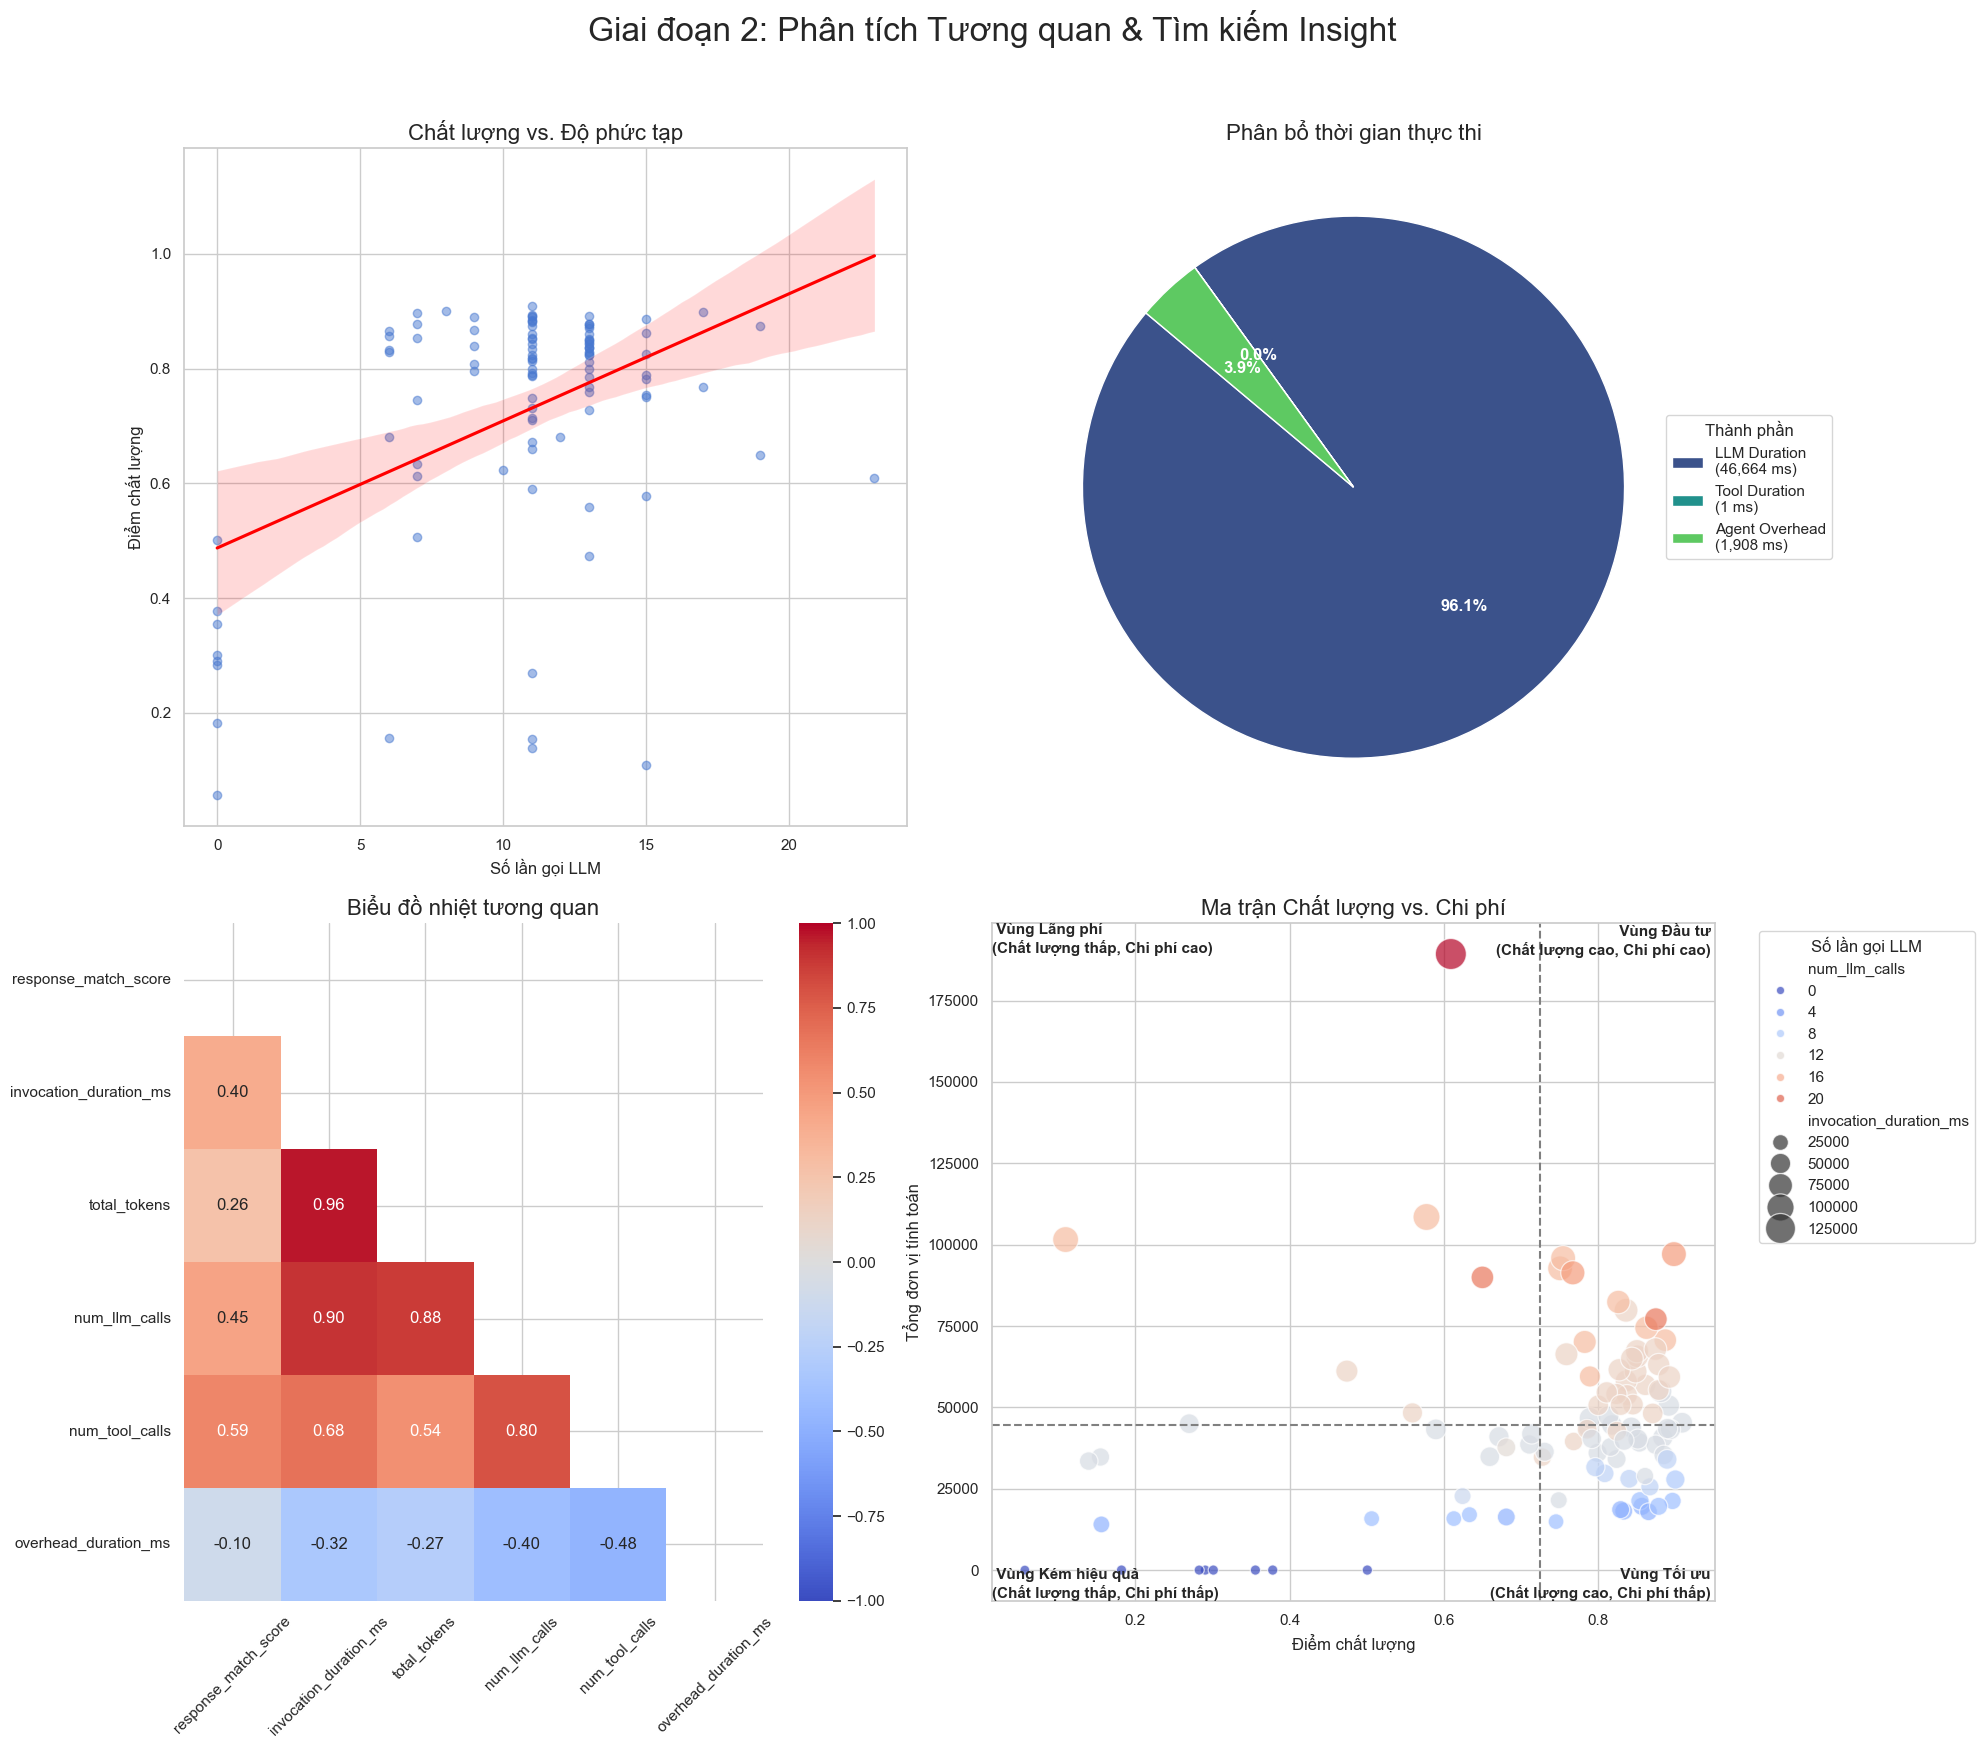

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Thiết lập chung cho bộ biểu đồ ---
sns.set_theme(style="whitegrid", palette="muted")
fig, axes = plt.subplots(2, 2, figsize=(20, 18)) 
fig.suptitle('Giai đoạn 2: Phân tích Tương quan & Tìm kiếm Insight', fontsize=24, y=0.97)


# --- A. Mối liên hệ giữa Chất lượng và Độ phức tạp ---
ax1 = axes[0, 0]
sns.regplot(
    data=cleaned_df, x='num_llm_calls', y='response_match_score', ax=ax1,
    scatter_kws={'alpha':0.5}, line_kws={'color':'red'}
)
ax1.set_title('Chất lượng vs. Độ phức tạp', fontsize=16)
ax1.set_xlabel('Số lần gọi LLM', fontsize=12)
ax1.set_ylabel('Điểm chất lượng', fontsize=12)


# --- B. Phân tích "Nút thắt cổ chai" về Hiệu suất ---
ax2 = axes[0, 1]
# Tính toán thời gian trung bình cho mỗi thành phần
mean_durations = cleaned_df[['llm_duration_ms', 'tool_duration_ms', 'overhead_duration_ms']].mean()
labels = [f'LLM Duration\n({mean_durations[0]:,.0f} ms)', 
          f'Tool Duration\n({mean_durations[1]:,.0f} ms)', 
          f'Agent Overhead\n({mean_durations[2]:,.0f} ms)']
wedges, texts, autotexts = ax2.pie(
    mean_durations, autopct='%1.1f%%', startangle=140,
    colors=sns.color_palette("viridis", 3), textprops={'color':"w", 'weight':'bold'}
)
ax2.legend(wedges, labels, title="Thành phần", loc="center left", bbox_to_anchor=(0.95, 0, 0.5, 1))
ax2.set_title('Phân bổ thời gian thực thi', fontsize=16)


# --- C. Tương quan giữa các Yếu tố (Bản đồ nhiệt) ---
ax3 = axes[1, 0]
corr_cols = [
    'response_match_score', 'invocation_duration_ms', 'total_tokens', 
    'num_llm_calls', 'num_tool_calls', 'overhead_duration_ms'
]
corr_matrix = cleaned_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, cmap='coolwarm', vmax=1.0, vmin=-1.0,
    annot=True, fmt=".2f", ax=ax3
)
ax3.set_title('Biểu đồ nhiệt tương quan', fontsize=16)
ax3.tick_params(axis='x', rotation=45)


# --- D. Phân tích Ma trận Chất lượng vs. Chi phí ---
# --- D. Phân tích Ma trận Chất lượng vs. Chi phí (ĐÃ SỬA LỖI) ---
ax4 = axes[1, 1]
mean_score = cleaned_df['response_match_score'].mean()
mean_cost = cleaned_df['total_tokens'].mean()
sns.scatterplot(
    data=cleaned_df, x='response_match_score', y='total_tokens', ax=ax4, alpha=0.7,
    hue='num_llm_calls', palette='coolwarm', size='invocation_duration_ms', sizes=(50, 500)
)
ax4.axvline(mean_score, color='grey', linestyle='--')
ax4.axhline(mean_cost, color='grey', linestyle='--')
ax4.set_title('Ma trận Chất lượng vs. Chi phí', fontsize=16)
ax4.set_xlabel('Điểm chất lượng', fontsize=12)
ax4.set_ylabel('Tổng đơn vị tính toán', fontsize=12)

# Thêm nhãn cho 4 góc phần tư với vị trí và tên đã được sửa lỗi
ax4.text(ax4.get_xlim()[1], ax4.get_ylim()[0], ' Vùng Tối ưu \n(Chất lượng cao, Chi phí thấp) ', ha='right', va='bottom', fontsize=11, weight='bold')
ax4.text(ax4.get_xlim()[1], ax4.get_ylim()[1], ' Vùng Đầu tư \n(Chất lượng cao, Chi phí cao) ', ha='right', va='top', fontsize=11, weight='bold')
ax4.text(ax4.get_xlim()[0], ax4.get_ylim()[1], ' Vùng Lãng phí \n(Chất lượng thấp, Chi phí cao) ', ha='left', va='top', fontsize=11, weight='bold')
ax4.text(ax4.get_xlim()[0], ax4.get_ylim()[0], ' Vùng Kém hiệu quả \n(Chất lượng thấp, Chi phí thấp) ', ha='left', va='bottom', fontsize=11, weight='bold')

ax4.legend(title='Số lần gọi LLM', bbox_to_anchor=(1.05, 1), loc='upper left')
import os

output_folder = './assets'
os.makedirs(output_folder, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại


# --- Hiển thị & Hoàn thiện ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_folder, 'overall_relation_and_insight.png')) # Lưu thành file ảnh riêng
plt.show()
plt.close()


Đang tạo 4 biểu đồ riêng lẻ...


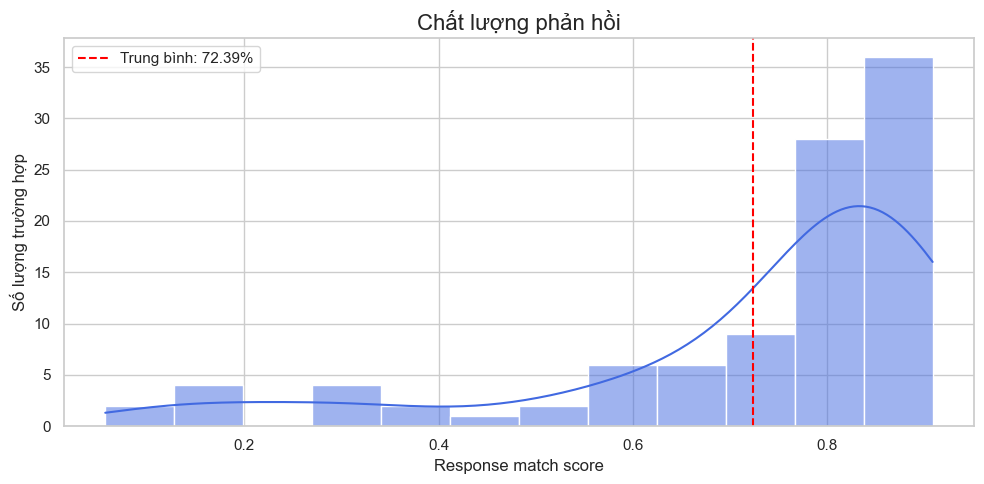

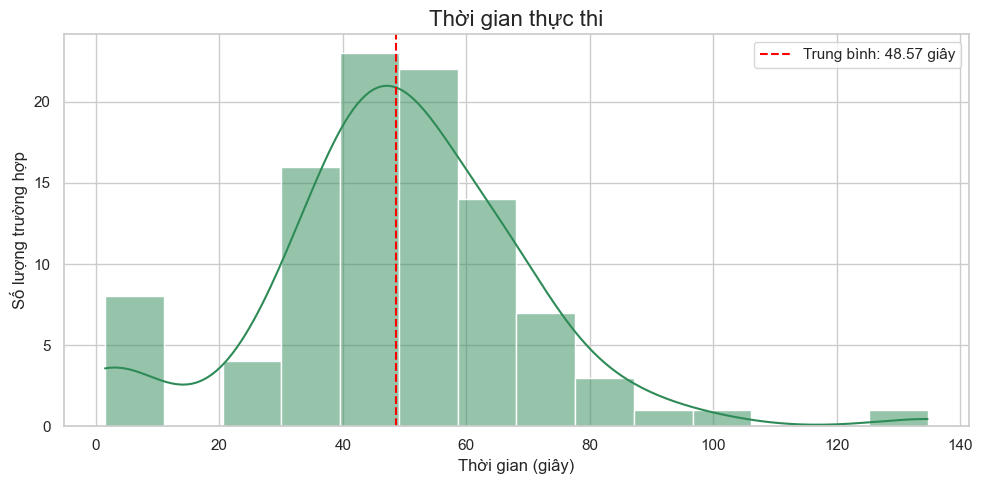

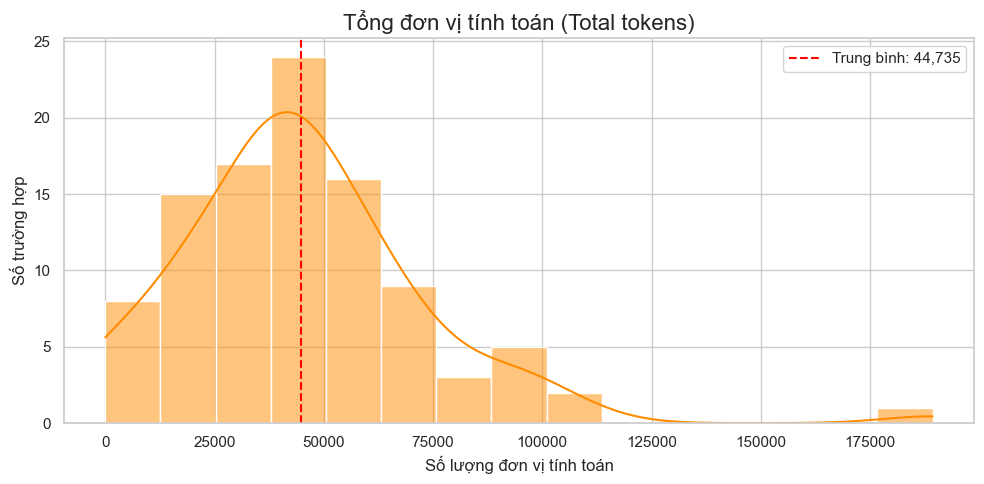

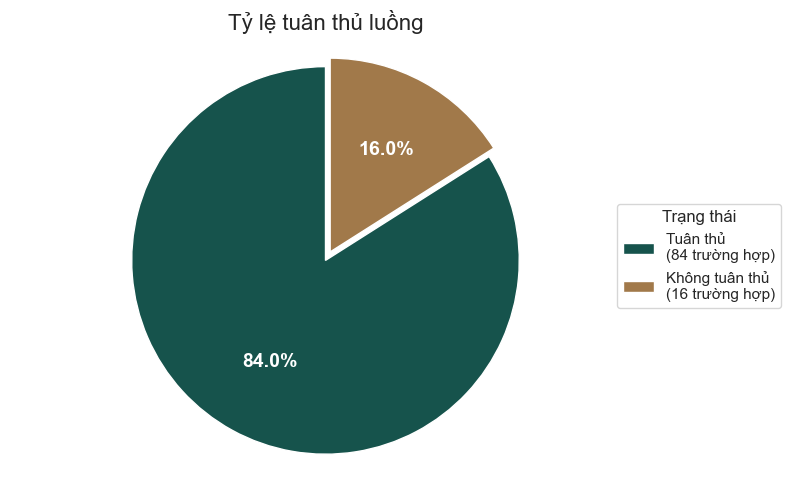


Hoàn tất! Đã tạo và lưu 4 tệp ảnh riêng lẻ.


In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Thiết lập chung ---
sns.set_theme(style="whitegrid")
print("Đang tạo 4 biểu đồ riêng lẻ...")

output_folder = "./assets"
os.makedirs(output_folder, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

# --- 1. Biểu đồ Phân phối Chất lượng ---
plt.figure(figsize=(10, 5))  # Tạo một figure mới cho biểu đồ này
ax1 = sns.histplot(
    data=cleaned_df, x="response_match_score", kde=True, color="royalblue"
)
mean_score = cleaned_df["response_match_score"].mean()
ax1.axvline(
    mean_score, color="red", linestyle="--", label=f"Trung bình: {mean_score:.2%}"
)
ax1.set_title("Chất lượng phản hồi", fontsize=16)
ax1.set_xlabel("Response match score", fontsize=12)
ax1.set_ylabel("Số lượng trường hợp", fontsize=12)
ax1.legend()
plt.tight_layout()
plt.savefig(
    os.path.join(output_folder, "01_quality_distribution.png")
)  # Lưu thành file ảnh riêng
plt.show()
plt.close()  # Đóng figure để giải phóng bộ nhớ

# --- 2. Biểu đồ Phân phối Hiệu suất ---
plt.figure(figsize=(10, 5))  # Tạo figure mới
duration_seconds = cleaned_df["invocation_duration_ms"] / 1000
ax2 = sns.histplot(duration_seconds, kde=True, color="seagreen")
mean_duration = duration_seconds.mean()
ax2.axvline(
    mean_duration,
    color="red",
    linestyle="--",
    label=f"Trung bình: {mean_duration:.2f} giây",
)
ax2.set_title("Thời gian thực thi", fontsize=16)
ax2.set_xlabel("Thời gian (giây)", fontsize=12)
ax2.set_ylabel("Số lượng trường hợp", fontsize=12)
ax2.legend()
plt.tight_layout()
plt.savefig(
    os.path.join(output_folder, "02_execution_time_distribution.png")
)  # Lưu thành file ảnh riêng
plt.show()
plt.close()

# --- 3. Biểu đồ Phân phối Chi phí ---
plt.figure(figsize=(10, 5))  # Tạo figure mới
ax3 = sns.histplot(data=cleaned_df, x="total_tokens", kde=True, color="darkorange")
mean_tokens = cleaned_df["total_tokens"].mean()
ax3.axvline(
    mean_tokens, color="red", linestyle="--", label=f"Trung bình: {mean_tokens:,.0f}"
)
ax3.set_title("Tổng đơn vị tính toán (Total tokens)", fontsize=16)
ax3.set_xlabel("Số lượng đơn vị tính toán", fontsize=12)
ax3.set_ylabel("Số trường hợp", fontsize=12)
ax3.legend()
plt.tight_layout()
plt.savefig(
    os.path.join(output_folder, "03_cost_distribution.png")
)  # Lưu thành file ảnh riêng
plt.show()
plt.close()

# --- 4. Biểu đồ Tỷ lệ Tuân thủ Luồng (Có legend) ---
plt.figure(figsize=(10, 5))  # Tạo figure mới
score_counts = cleaned_df["tool_trajectory_avg_score"].value_counts()
if len(score_counts) >= 2:
    labels = [
        f"Tuân thủ\n({score_counts.iloc[0]} trường hợp)",
        f"Không tuân thủ\n({score_counts.iloc[1]} trường hợp)",
    ]
elif len(score_counts) == 1:
    labels = [
        f"Tuân thủ\n({score_counts.iloc[0]} trường hợp)" if score_counts.index[0] == 1.0 else
        f"Không tuân thủ\n({score_counts.iloc[0]} trường hợp)"
    ]
sizes = [score_counts.get(1.0, 0), score_counts.get(0.0, 0)]
colors=sns.color_palette("cubehelix", 3)
explode = (0.05, 0)

# Bỏ `labels` khỏi đây để chúng không hiện trên biểu đồ
wedges, texts, autotexts = plt.pie(
    sizes,
    explode=explode,
    colors=colors,
    autopct="%1.1f%%",  # Giữ lại phần trăm
    shadow=False,
    startangle=90,
    textprops={"fontsize": 14, "weight": "bold", "color": "white"},
)

# Thêm legend vào bên cạnh biểu đồ
plt.legend(
    wedges,
    labels,
    title="Trạng thái",
    loc="center left",
    bbox_to_anchor=(0.95, 0, 0.5, 1),
)

plt.title("Tỷ lệ tuân thủ luồng", fontsize=16)
plt.axis("equal")
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Điều chỉnh layout để có chỗ cho legend
plt.savefig(os.path.join(output_folder, "04_workflow_compliance_ratio.png"))
plt.show()
plt.close()

print("\nHoàn tất! Đã tạo và lưu 4 tệp ảnh riêng lẻ.")

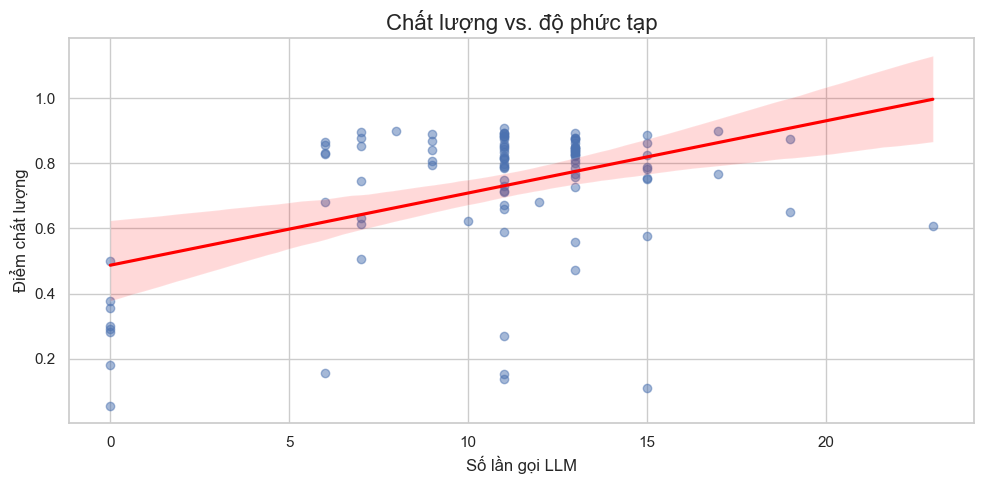

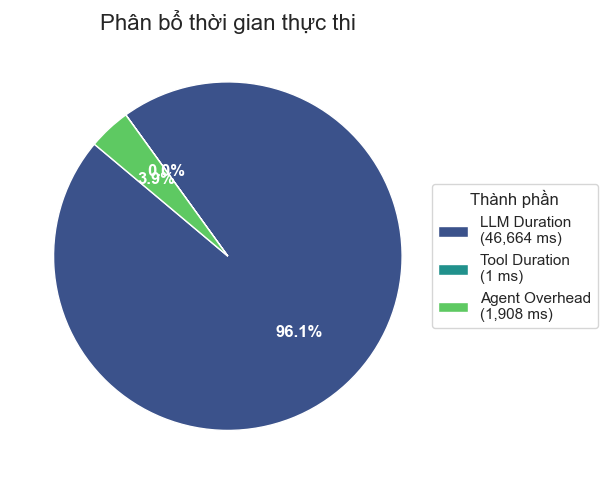

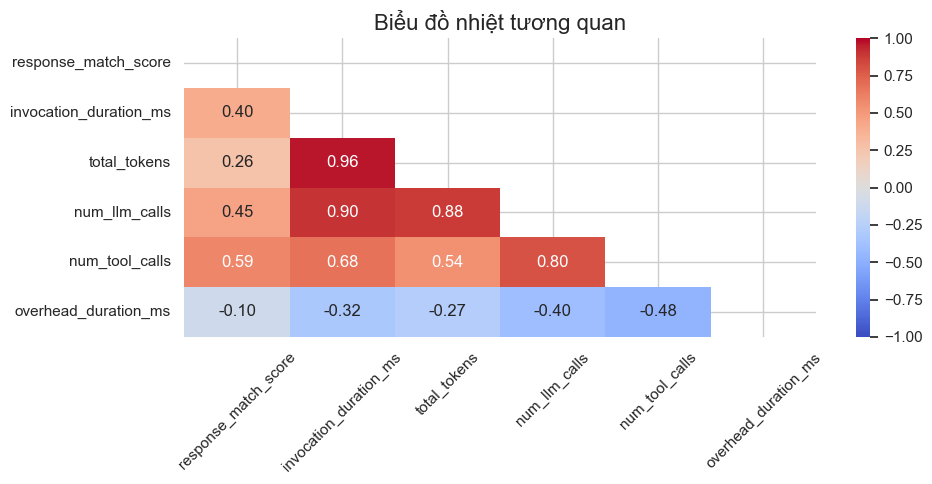

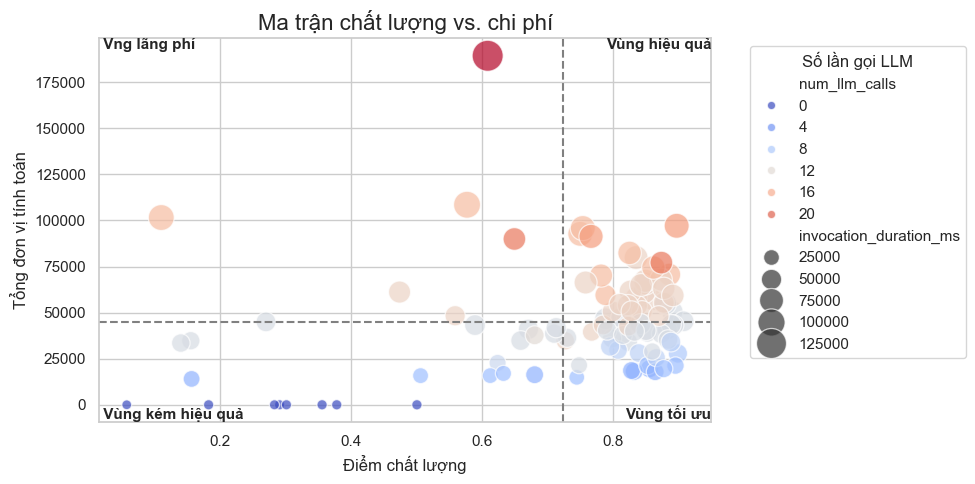

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

output_folder = "./assets"
os.makedirs(output_folder, exist_ok=True)

# --- A. Chất lượng vs. Độ phức tạp ---
plt.figure(figsize=(10, 5))
sns.regplot(
    data=cleaned_df,
    x="num_llm_calls",
    y="response_match_score",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.title("Chất lượng vs. độ phức tạp", fontsize=16)
plt.xlabel("Số lần gọi LLM", fontsize=12)
plt.ylabel("Điểm chất lượng", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "05_quality_vs_complexity.png"))
plt.show()
plt.close()


# --- B. Phân bổ thời gian thực thi ---
plt.figure(figsize=(10, 5))
mean_durations = cleaned_df[
    ["llm_duration_ms", "tool_duration_ms", "overhead_duration_ms"]
].mean()
labels = [
    f'LLM Duration\n({mean_durations.loc["llm_duration_ms"]:,.0f} ms)',
    f'Tool Duration\n({mean_durations.loc["tool_duration_ms"]:,.0f} ms)',
    f'Agent Overhead\n({mean_durations.loc["overhead_duration_ms"]:,.0f} ms)',
]
wedges, texts, autotexts = plt.pie(
    mean_durations,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("viridis", 3),
    textprops={"color": "w", "weight": "bold"},
)
plt.legend(
    wedges,
    labels,
    title="Thành phần",
    loc="center left",
    bbox_to_anchor=(0.95, 0, 0.5, 1),
)
plt.title("Phân bổ thời gian thực thi", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "06_execution_time_breakdown.png"))
plt.show()
plt.close()


# --- C. Biểu đồ nhiệt tương quan ---
plt.figure(figsize=(10, 5))
corr_cols = [
    "response_match_score",
    "invocation_duration_ms",
    "total_tokens",
    "num_llm_calls",
    "num_tool_calls",
    "overhead_duration_ms",
]
corr_matrix = cleaned_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, cmap="coolwarm", vmax=1.0, vmin=-1.0, annot=True, fmt=".2f"
)
plt.title("Biểu đồ nhiệt tương quan", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "07_correlation_heatmap.png"))
plt.show()
plt.close()


# --- D. Ma trận Chất lượng vs. Chi phí ---
plt.figure(figsize=(10, 5))
mean_score = cleaned_df["response_match_score"].mean()
mean_cost = cleaned_df["total_tokens"].mean()
sns.scatterplot(
    data=cleaned_df,
    x="response_match_score",
    y="total_tokens",
    alpha=0.7,
    hue="num_llm_calls",
    palette="coolwarm",
    size="invocation_duration_ms",
    sizes=(50, 500),
)
plt.axvline(mean_score, color="grey", linestyle="--")
plt.axhline(mean_cost, color="grey", linestyle="--")
plt.title("Ma trận chất lượng vs. chi phí", fontsize=16)
plt.xlabel("Điểm chất lượng", fontsize=12)
plt.ylabel("Tổng đơn vị tính toán", fontsize=12)

# Nhãn 4 vùng
plt.text(
    plt.xlim()[1],
    plt.ylim()[0],
    "Vùng tối ưu",
    ha="right",
    va="bottom",
    fontsize=11,
    weight="bold",
)
plt.text(
    plt.xlim()[1],
    plt.ylim()[1],
    "Vùng hiệu quả",
    ha="right",
    va="top",
    fontsize=11,
    weight="bold",
)
plt.text(
    plt.xlim()[0],
    plt.ylim()[1],
    " Vng lãng phí",
    ha="left",
    va="top",
    fontsize=11,
    weight="bold",
)
plt.text(
    plt.xlim()[0],
    plt.ylim()[0],
    " Vùng kém hiệu quả",
    ha="left",
    va="bottom",
    fontsize=11,
    weight="bold",
)

plt.legend(title="Số lần gọi LLM", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "08_quality_vs_cost.png"))
plt.show()
plt.close()